In [1]:
import psycopg2
import pandas as pd
import numpy as np
import mariadb
import json
import os
import shutil
import subprocess
from pathlib import Path
import pyodbc
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.spatial import distance
import pickle
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
import seaborn as sns

In [2]:
os.getcwd()

'C:\\Users\\tsuma.thomas\\Documents\\Cropnuts\\DSML158\\SoilAnalysis'

In [3]:
soil_df = pd.read_csv("output/soil_analysis_cleaned.csv")

C:\Users\tsuma.thomas\AppData\Local\Temp\ipykernel_5332\3696429364.py:1: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  soil_df = pd.read_csv("output/soil_analysis_cleaned.csv")


In [4]:
soil_df

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,sample_code,batch_date,analysis_name,chemical_name,result,unit_name
0,6168,6168,3457,FA611-161SA0001,2019-04-29 00:00:00.000,Complete Soil Analysis with Recommendations,organic_carbon,1.30,%
1,6329,6329,3532,FA807-384SA0001,2019-10-30 00:00:00.000,Complete Soil Analysis with Recommendations,organic_carbon,3.37,%
2,7604,7604,4311,CC004SA0484,2019-05-06 00:00:00.000,Complete Soil Analysis with Recommendations,organic_carbon,1.68,%
3,8755,8755,5056,CC004SA0485,2019-05-06 00:00:00.000,Complete Soil Analysis with Recommendations,organic_carbon,2.23,%
4,14040,14040,7262,FA807-384SA0002,2019-10-30 00:00:00.000,Complete Soil Analysis with Recommendations,organic_carbon,2.81,%
...,...,...,...,...,...,...,...,...,...
5873849,1949821,1949821,1291549,CC003SA0055,2015-09-15 00:00:00.000,Saturated Soil Paste Extract,sar,7.89,ppm
5873850,1949825,1949825,1291551,CC003SA0054,2015-09-15 00:00:00.000,Saturated Soil Paste Extract,sar,8.58,ppm
5873851,5369834,5369834,3385441,CA627SA0002,2023-04-19 12:06:00.000,Salmonella spp,e_coli,600.00,cfu/g
5873852,5369848,5369848,3385446,CA627SA0003,2023-04-19 12:06:00.000,Salmonella spp,e_coli,90.00,cfu/g


In [5]:
new_samples_df = soil_df.loc[soil_df['batch_date'] > '2024-05-21'] 
soil_df = soil_df.loc[soil_df['batch_date'] <= '2024-05-21'] 

In [20]:
soil_df.analysis_name.value_counts().to_csv("output/modelling_analysis_value_counts.csv")
new_samples_df.analysis_name.value_counts().to_csv("output/test_analysis_value_counts.csv")

In [6]:
soil_df['chemical_name'] = [ i.lower().replace(" ","_").replace(".","").replace("(","").replace(")","").replace("/","").strip() for i in soil_df['chemical_name'] ]

C:\Users\tsuma.thomas\AppData\Local\Temp\ipykernel_5332\4255157908.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  soil_df['chemical_name'] = [ i.lower().replace(" ","_").replace(".","").replace("(","").replace(")","").replace("/","").strip() for i in soil_df['chemical_name'] ]


 Basic Soil Analysis with Recommendations
599
599
 Complete Soil Analysis (M3)
78
78
 Complete Soil Analysis with Recommendations
769
769
 Fe & P
48
48
% Gypsum
40
40
% Organic Matter (OM)
5264
5264
% Soil Nitrogen (N)
5228
5228
AFSIS Std Wet Chemistry Soil Analysis
13086
13086
ATA Ethiopia Soil Analysis
4687
4687
Advanced Biological Farming Soil Audit
253
253
Aluminium in soil 
24


FileNotFoundError: [Errno 2] No such file or directory: 'output/boxplots/Aluminium in soil /exchangeable_acidity.png'

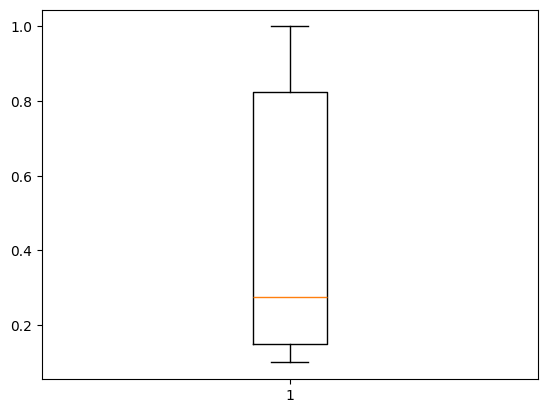

In [7]:
for analysis in np.unique(soil_df['analysis_name']):
    print(analysis)
    df_ = soil_df.loc[soil_df['analysis_name']==analysis]
    df_ = pd.pivot_table(data=df_, values="result", index="sample_code", columns="chemical_name")
    print(len(df_))

    os.makedirs(f"output/boxplots/{analysis}",exist_ok=True)
    for column in df_.columns:
        # print(column)
        os.makedirs(f"output/chemical_null_count",exist_ok=True)
        plt.boxplot(df_[column])
        plt.savefig(f"output/boxplots/{analysis}/{column}.png")
        plt.clf()
        outlier_threshold = df_[column].quantile(0.99)
        # df_ = df_.loc[df_[column] <= outlier_threshold]
    df_.describe().to_csv(f"output/chemical_null_count/{analysis}.csv")
    print(len(df_))
    if(len(df_) == 0):
        continue
    os.makedirs(f"output/analysis",exist_ok=True)
    df_.to_csv(f"output/analysis/{analysis}.csv")
    

In [8]:
# for analysis_file in os.listdir("output/analysis"):
#     os.makedirs("./output/pairplots",exist_ok=True)
#     analysis_df = pd.read_csv(f"output/analysis/{analysis_file}",index_col=0)
#     print(analysis_file.replace('.csv',''))
#     sns.pairplot(analysis_df)
#     print('Saving')
#     plt.savefig(f"output/pairplots/{analysis_file.replace('.csv','')}.png")
#     print('Saved')
#     plt.clf()

In [8]:
for analysis_file in os.listdir("output/analysis"):
    print(analysis_file)
    analysis_df = pd.read_csv(f"output/analysis/{analysis_file}",index_col=0)

    imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
    analysis_df = pd.DataFrame(imp_mean.fit_transform(analysis_df), columns=analysis_df.columns, index=analysis_df.index)
    pickle.dump(imp_mean, open(f"models/imputers/{analysis_file.replace('csv','pkl')}","wb"))
    if(len(analysis_df.columns) == 1):
        print(analysis_file)
        continue
    sc = StandardScaler()
    pca = PCA()
    analysis_scaled = sc.fit_transform(analysis_df)
    pca.fit(analysis_scaled)
    pca_explained_variance_df = pd.DataFrame(zip(analysis_df.columns,pca.explained_variance_ratio_))
    pca_explained_variance_df.to_csv(f"output/pca_explained_variance_ratio/{analysis_file}")

    n_components = len(pca_explained_variance_df.loc[pca_explained_variance_df[1]>0.1])
    if n_components < 2:
        n_components = 2
        pca_explained_variance_df = pca_explained_variance_df.loc[pca_explained_variance_df[1]>0]
    else:
        pca_explained_variance_df = pca_explained_variance_df.loc[pca_explained_variance_df[1]>0.1]
    
    pca_chems = pca_explained_variance_df[0]
    pca = PCA(n_components=n_components)
    analysis_scaled = sc.fit_transform(analysis_df)
    pca_reduced_df = pca.fit_transform(analysis_scaled)
    analysis_scaled = pd.DataFrame(analysis_scaled,index=analysis_df.index)
    pca_reduced_df = pd.DataFrame(pca_reduced_df,index=analysis_df.index, columns=pca_chems[0:n_components])
    analysis_scaled.to_csv(f"output/analysis_scaled/{analysis_file}")
    pca_reduced_df.to_csv(f"output/pca_df/{analysis_file}")
    pickle.dump(sc, open(f"models/scalers/{analysis_file.replace('csv','pkl')}","wb"))
    pickle.dump(pca, open(f"models/pca/{analysis_file.replace('csv','pkl')}","wb"))

 Basic Soil Analysis with Recommendations.csv
 Basic Soil Analysis with Recommendations.csv
 Complete Soil Analysis (M3).csv
 Complete Soil Analysis (M3).csv
 Complete Soil Analysis with Recommendations.csv
 Fe & P.csv
 Fe & P.csv
% Gypsum.csv
% Gypsum.csv
% Organic Matter (OM).csv
% Soil Nitrogen (N).csv
Advanced Biological Farming Soil Audit.csv
AFSIS Std Wet Chemistry Soil Analysis.csv
Aluminium in soil .csv
Aluminium in soil .csv
Ammonium Acetate Cu & Zn.csv
Ammonium Acetate Cu & Zn.csv
ATA Ethiopia Soil Analysis.csv
Available Nitrogen in Soil.csv
Available Nitrogen.csv
Basic Hybrid Plus.csv
Basic Hybrid Plus.csv
Basic Soil Analysis (BSA).csv
Basic Soil Analysis with Recommendations.csv
Basic Soil Analysis with Recommendations.csv
Basic Soil Analysis.csv
Basic Soil Scan.csv
Basic Soil Scan.csv
Basis Soil Scan.csv
Basis Soil Scan.csv
Bio-available Nutrient Analysis.csv
Boron Analysis - Hot water.csv
Boron Analysis - Hot water.csv
Bray 1 in Soil.csv
Bray 1 in Soil.csv
Calcium Carbona

In [9]:
for analysis_file in os.listdir("output/pca_df"):
    print(analysis_file)
    os.makedirs(f"output/mahalanobis_distance",exist_ok=True)
    pca_reduced_df = pd.read_csv(f"output/pca_df/{analysis_file}",index_col=0)
    # if len(pca_reduced_df.columns) < 2:
        # continue
    mu = np.mean(pca_reduced_df, axis=0)
    sigma = np.cov(pca_reduced_df.T)
    os.makedirs(f"output/pca_df",exist_ok=True)
    try:
        pca_reduced_df['mahalanobis_distance'] = [distance.mahalanobis(pca_reduced_df.iloc[i], mu, np.linalg.inv(sigma)) for i in range(len(pca_reduced_df)) ]
    except:
        continue
    pca_reduced_df.to_csv(f"output/mahalanobis_distance/{analysis_file}")

 Complete Soil Analysis with Recommendations.csv
% Organic Matter (OM).csv
% Soil Nitrogen (N).csv
Advanced Biological Farming Soil Audit.csv
AFSIS Std Wet Chemistry Soil Analysis.csv
ATA Ethiopia Soil Analysis.csv
Available Nitrogen in Soil.csv
Available Nitrogen.csv
Basic Soil Analysis (BSA).csv
Basic Soil Analysis with Recommendations.csv
Basic Soil Analysis.csv
Bio-available Nutrient Analysis.csv
Calcium Carbonates (Soil).csv
Carbon Analysis.csv
Complete Soil + Bio-available Nutrients Analysis.csv
Complete Soil +Hp Analysis.csv
Complete Soil Analysis (Calcareous).csv
Complete Soil Analysis (data only).csv
Complete Soil Analysis (M3).csv
Complete Soil Analysis + Exch. Acidity.csv
Complete Soil Analysis - Co & Si (IFDC).csv
Complete Soil Analysis with Recommendations.csv
Complete Soil Analysis.csv
EC [Salts] Analysis.csv
Estimated Available Water Holding Capacity.csv
Exch. Aluminium.csv
Exchangable Aluminium.csv
Exchangeable Acidity (Hp) Analysis.csv
Exchangeable Acidity (Hp) in Soil

In [10]:
mahalanobis_threshold_dict = {}
for analysis_file in os.listdir("output/mahalanobis_distance"):
    print(analysis_file)
    os.makedirs(f"output/mahalanobis_distance_upper_quantile",exist_ok=True)
    os.makedirs(f"output/mahalanobis_boxplots",exist_ok=True)
    analysis = analysis_file.replace(".csv","")
    mahalanobis_df = pd.read_csv(f"output/mahalanobis_distance/{analysis_file}",index_col=0)
    upper_quantile = (mahalanobis_df['mahalanobis_distance'].quantile(0.95))
    mahalanobis_threshold_dict[analysis_file.replace(".csv","")] = upper_quantile
    mahalanobis_df.loc[mahalanobis_df['mahalanobis_distance'] >= upper_quantile].to_csv(f"output/mahalanobis_distance_upper_quantile/{analysis_file}")
    plt.boxplot(mahalanobis_df['mahalanobis_distance'])
    plt.savefig(f"output/mahalanobis_boxplots/{analysis}.png")
    plt.clf()
pickle.dump(mahalanobis_threshold_dict, open("mahalanobis_thresholds.dict","wb"))

 Complete Soil Analysis with Recommendations.csv
% Organic Matter (OM).csv
% Soil Nitrogen (N).csv
Advanced Biological Farming Soil Audit.csv
AFSIS Std Wet Chemistry Soil Analysis.csv
ATA Ethiopia Soil Analysis.csv
Available Nitrogen in Soil.csv
Available Nitrogen.csv
Basic Soil Analysis (BSA).csv
Basic Soil Analysis with Recommendations.csv
Basic Soil Analysis.csv
Bio-available Nutrient Analysis.csv
Calcium Carbonates (Soil).csv
Carbon Analysis.csv
Complete Soil + Bio-available Nutrients Analysis.csv
Complete Soil +Hp Analysis.csv
Complete Soil Analysis (Calcareous).csv
Complete Soil Analysis (data only).csv
Complete Soil Analysis (M3).csv
Complete Soil Analysis + Exch. Acidity.csv
Complete Soil Analysis - Co & Si (IFDC).csv
Complete Soil Analysis with Recommendations.csv
Complete Soil Analysis.csv
EC [Salts] Analysis.csv
Estimated Available Water Holding Capacity.csv
Exch. Aluminium.csv
Exchangable Aluminium.csv
Exchangeable Acidity (Hp) Analysis.csv
Exchangeable Acidity (Hp) in Soil

<Figure size 640x480 with 0 Axes>

In [11]:
mahalanobis_threshold_dict

{' Complete Soil Analysis with Recommendations': 3.6354873620170194,
 '% Organic Matter (OM)': 2.4820340988782346,
 '% Soil Nitrogen (N)': 2.048581392545839,
 'Advanced Biological Farming Soil Audit': 2.6277811147643377,
 'AFSIS Std Wet Chemistry Soil Analysis': 3.550887899802413,
 'ATA Ethiopia Soil Analysis': 2.4081525584472767,
 'Available Nitrogen in Soil': 1.1675633245872705,
 'Available Nitrogen': 2.004405411942333,
 'Basic Soil Analysis (BSA)': 2.889488457154326,
 'Basic Soil Analysis with Recommendations': 2.237693185943912,
 'Basic Soil Analysis': 3.0085645392568483,
 'Bio-available Nutrient Analysis': 2.6727884621670746,
 'Calcium Carbonates (Soil)': 3.9381713169037664,
 'Carbon Analysis': 2.0564997580078015,
 'Complete Soil + Bio-available Nutrients Analysis': 2.763739839637341,
 'Complete Soil +Hp Analysis': 3.355543128140684,
 'Complete Soil Analysis (Calcareous)': 2.8073289689165652,
 'Complete Soil Analysis (data only)': 1.515033856374803,
 'Complete Soil Analysis (M3)':

In [13]:
pd.DataFrame({'analysis_name':mahalanobis_threshold_dict.keys()}).to_csv("output/analyses_in_models.csv")

In [14]:
conn_lims = pyodbc.connect("Driver={SQL Server};"
                            "Server=192.168.5.18\CROPNUT;"
                            "Database=cropnuts;"
                            "uid=thomasTsuma;pwd=GR^KX$uRe9#JwLc6")

In [15]:
analysis_dict = pd.read_sql(f"""SELECT analysis_id, LTRIM(RTRIM(analysis_name)) as analysis_name FROM Analysis  ORDER BY analysis_name""",con=conn_lims).set_index("analysis_id").to_dict()['analysis_name']
pickle.dump(analysis_dict, open("analysis.dict","wb"))

C:\Users\tsuma.thomas\AppData\Local\Temp\ipykernel_5332\1909864603.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  analysis_dict = pd.read_sql(f"""SELECT analysis_id, LTRIM(RTRIM(analysis_name)) as analysis_name FROM Analysis  ORDER BY analysis_name""",con=conn_lims).set_index("analysis_id").to_dict()['analysis_name']


In [16]:
reverse_analysis_dict = pd.read_sql(f"""SELECT analysis_id, LTRIM(RTRIM(analysis_name)) as analysis_name FROM Analysis ORDER BY analysis_name""",con=conn_lims).set_index("analysis_name").to_dict()['analysis_id']
reverse_analysis_dict

C:\Users\tsuma.thomas\AppData\Local\Temp\ipykernel_5332\3771434913.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  reverse_analysis_dict = pd.read_sql(f"""SELECT analysis_id, LTRIM(RTRIM(analysis_name)) as analysis_name FROM Analysis ORDER BY analysis_name""",con=conn_lims).set_index("analysis_name").to_dict()['analysis_id']


{'% Gypsum': 540,
 '% Nitrogen (RSSP 2)': 647,
 '% Organic Matter': 258,
 '% Organic Matter (RSSP 2)': 646,
 '% Soil Nitrogen': 18,
 '%Assay': 27235,
 '%N (RSSP 2)': 652,
 '%OM (RSSP 2)': 651,
 '%P,%S Analysis(Super Calcium)': 383,
 '1:2 Soil Volume Extract': 294,
 '1:2 soil volume extract': 25,
 '1:2 Soil Volume Extract (Data Only)': 27339,
 '1:2 Vol Extract for BLGG': 317,
 '20:12:12 (N,P205,K20) Analysis': 840,
 'Absorbance at 254nm': 26936,
 'Acid Detergent Fibre': 27063,
 'Acid Insoluble Ash': 27417,
 'Acid Insoluble Matter': 27108,
 'Acid titration': 26647,
 'Acid Value': 26971,
 'Advanced Biological Farming Soil Audit': 26521,
 'Advanced Soil Health Analysis': 27181,
 'Aerobic Mesophilic Count': 26649,
 'Aflatoxin': 26794,
 'Aflatoxin AFB1': 26938,
 'Aflatoxin B1': 26939,
 'Aflatoxin in feed': 767,
 'Aflatoxin M1': 27469,
 'Aflatoxin Total': 766,
 'AfSIS Standard Leaf Analysis': 633,
 'AFSIS Std Wet Chemistry Soil Analysis': 589,
 'Aggregate Stability': 26727,
 'Agrifi Soil Micr

In [17]:
[reverse_analysis_dict[i] for i in soil_df['analysis_name'].unique() if i in reverse_analysis_dict.keys()]

[221,
 751,
 117,
 568,
 589,
 529,
 26597,
 525,
 4,
 27461,
 27383,
 524,
 26684,
 779,
 58,
 504,
 764,
 27278,
 808,
 183,
 523,
 697,
 811,
 522,
 609,
 526,
 518,
 528,
 220,
 26737,
 531,
 297,
 532,
 539,
 601,
 236,
 209,
 26570,
 704,
 26603,
 27189,
 26521,
 219,
 26519,
 27211,
 27210,
 296,
 26758,
 229,
 540,
 905,
 27283,
 548,
 26564,
 198,
 27186,
 26681,
 939,
 27458]

In [21]:
test = []
for sample in new_samples_df.sample_code.unique():
    res = {}
    tmp_ = new_samples_df.loc[new_samples_df.sample_code == sample]
    res['sample_code'] = sample
    res['analysis_id'] = [ reverse_analysis_dict[i] for i in tmp_.analysis_name.unique() if i in reverse_analysis_dict.keys() ]
    for index,row in tmp_.iterrows():
        if row['result'] >= 0 :
            res[row['chemical_name']] = {'result': row['result'], 'unit_name': str(row['unit_name'])}
        else:
            res[row['chemical_name']] = {'result': 0, 'unit_name': row['unit_name']}
    test.append(res)

In [22]:
str(test).replace("'",'"')

'[{"sample_code": "CB044SA0642", "analysis_id": [221], "organic_carbon": {"result": 1.53, "unit_name": "%"}, "c/n_ratio": {"result": 10.9, "unit_name": "nan"}, "ec_salts": {"result": 179.0, "unit_name": "uS/cm"}, "boron": {"result": 1.29, "unit_name": "ppm"}, "copper": {"result": 14.0, "unit_name": "ppm"}, "ph": {"result": 7.56, "unit_name": "nan"}, "total_nitrogen": {"result": 0.14, "unit_name": "%"}, "zinc": {"result": 19.6, "unit_name": "ppm"}, "calcium": {"result": 4490.0, "unit_name": "ppm"}, "magnesium": {"result": 726.0, "unit_name": "ppm"}, "potassium": {"result": 1230.0, "unit_name": "ppm"}, "sodium": {"result": 54.6, "unit_name": "ppm"}, "sulphur": {"result": 48.2, "unit_name": "ppm"}, "manganese": {"result": 253.0, "unit_name": "ppm"}, "iron": {"result": 85.4, "unit_name": "ppm"}}, {"sample_code": "CB044SA0639", "analysis_id": [221], "organic_carbon": {"result": 1.71, "unit_name": "%"}, "c/n_ratio": {"result": 12.2, "unit_name": "nan"}, "ec_salts": {"result": 226.0, "unit_na

In [47]:
req_body = test
_ = pd.DataFrame(req_body)
unit_decision = pd.read_csv("output/soil_unit_per_chemical_decision.csv")
analysis_dict = pickle.load(open("analysis.dict","rb"))
mahalanobis_thresholds = pickle.load(open("mahalanobis_thresholds.dict","rb"))
result = {}
_df = _.explode('analysis_id', ignore_index=True)

for index,row in _df.iterrows():
    sample_code = row['sample_code']
    import math
    analysis_id = row['analysis_id']
    if math.isnan(analysis_id):
        continue
    row['analysis_name'] = analysis_dict[analysis_id]
    analysis = row['analysis_name']
    if sample_code not in result.keys():
        result[sample_code] = []
    if analysis not in mahalanobis_thresholds.keys():
        result[sample_code].append({"sample_code": sample_code,"status":"warning", "message": f"Analysis not in models", "details": f"Analysis: {analysis} is not in the list of defined models" })   
        continue     
    scaler = pickle.load(open(f"models/scalers/{analysis}.pkl","rb"))
    pca = pickle.load(open(f"models/pca/{analysis}.pkl","rb"))
    imputer = pickle.load(open(f"models/imputers/{analysis}.pkl","rb"))
    pca_df = pd.read_csv(f"output/pca_df/{analysis}.csv",index_col=0)
    analysis_df = pd.read_csv(f"output/analysis/{analysis}.csv",index_col=0)

    

    try :
        tmp_df = pd.DataFrame(row).T
        for col in tmp_df.columns:
            tmp_df = tmp_df.rename(columns={col: col.lower().replace(" ","_").replace(".","").replace("(","").replace(")","").replace("/","").strip()})
        tmp_df = tmp_df[analysis_df.columns]
    except Exception as e:
        result[sample_code].append({"sample_code": sample_code,"status":"warning", "message": f"Missing parameters for analysis_id: {analysis}", "details": f"Expected parameters are {','.join(pca_df.columns)} for analysis: {analysis}" })
        continue
    failed_units_comparison = {}    
    for col in pca_df.columns:
        expected_units = unit_decision.loc[(unit_decision['crop'] == analysis) & (unit_decision['chemical_name'] == col)]
        print(expected_units)
        import math
        if type(row[col]) != dict and math.isnan(row[col]):
            failed_units_comparison[col] = {}
            failed_units_comparison[col]['expected_units'] = expected_units['unit_name'].tolist()[0]
            failed_units_comparison[col]['units_provided'] = None
            print(col)
            print(failed_units_comparison)
        elif row[col]['unit_name'] !=   expected_units['unit_name'].tolist()[0]:
            failed_units_comparison[col] = {}
            failed_units_comparison[col]['expected_units'] = expected_units['unit_name'].tolist()[0]
            failed_units_comparison[col]['units_provided'] = row[col]['units']
        else:
            continue    
    if len(failed_units_comparison.keys()) > 0:
        result[sample_code].append({"sample_code": sample_code,"status":"warning", "message": f"Wrong units provided", "details": f"Expected units are {str(failed_units_comparison)} for analysis: {analysis}" })
        continue
    for col in analysis_df.columns:
        if type(row[col]) == dict:
            row[col] = row[col]['result']
    
    out_of_bounds_chems = [ ]
    for col in tmp_df.columns:
        if col == "sample_code":
            continue
        if col == "ec_salts":
            if row[col] >= 105 or row[col] <= 95:
                out_of_bounds_chems.append("ec_salts out of bounds. Allowed bounds are 95 - 105")
        if col == "Charge Balance":
            if row[col] < -1:
                out_of_bounds_chems.append("Charge Balance out of bounds. Allowed lower boundary is -10. ")       
        elif col.lower() == "total suspended solids" and row['analysis_name'].lower() == "total suspended solids":
            if row[col] > 1:
                out_of_bounds_chems.append("total suspended solids out of bounds. If analysis is total suspended solids is <1 then total suspended solids check should be <1  . ")         
    if len(out_of_bounds_chems) > 0:
        result[sample_code].append({"sample_code": sample_code,"status":"warning", "message": f"Out of bounds", "details": f"{'.'.join(out_of_bounds_chems)}" })
        continue    

    tmp_df = pd.DataFrame(row).T[analysis_df.columns]
    tmp_df = imputer.transform(tmp_df)
    df_scaled = scaler.transform(tmp_df)
    df_pca = pd.DataFrame(pca.transform(df_scaled))

    mu = np.mean(pca_df, axis=0)
    sigma = np.cov(pca_df.T)

    mahalanobis_distance = distance.mahalanobis(df_pca.iloc[0], mu, np.linalg.inv(sigma))


    expected_md = mahalanobis_thresholds[analysis]

    if mahalanobis_distance > expected_md:
        result[sample_code].append({"sample_code": sample_code,"status":"fail", "message": "Mahalanobis distance exceeds threshold", "details":f"Mahalanobis distance of {mahalanobis_distance} exceeds threshold of {expected_md} for analysis: {analysis}" })
    else:
        result[sample_code].append({"sample_code": sample_code,"status":"pass","message": "Mahalanobis distance within threshold", "details":f"Mahalanobis distance of {mahalanobis_distance} is within threshold of {expected_md} for analysis: {analysis}" })
          

    Unnamed: 0                                         crop chemical_name  \
3            0  Complete Soil Analysis with Recommendations         boron   
26           0  Complete Soil Analysis with Recommendations         boron   
45           0  Complete Soil Analysis with Recommendations         boron   

   unit_name  
3        ppm  
26       ppm  
45       ppm  
Empty DataFrame
Columns: [Unnamed: 0, crop, chemical_name, unit_name]
Index: []


KeyError: 'cn_ratio'

In [43]:
unit_decision = pd.read_csv("soil_unit_per_chemical_decision.csv")


In [44]:
unit_decision

,Unnamed: 0,crop,chemical_name,unit_name
0,0,Complete Soil Analysis,ec_salts,uS/cm
1,0,Complete Soil Analysis,exchangeable_aluminium,uS/cm
2,0,Complete Soil Analysis,ph,NaN
3,0,Complete Soil Analysis,aluminium,ppm
4,0,Complete Soil Analysis,boron,ppm
...,...,...,...,...
103,0,Heavy Metals Analysis,ec_salts,mS/cm
104,0,Heavy Metals Analysis,cec,meq/100g
105,0,Heavy Metals Analysis,calcium,ppm
106,0,Heavy Metals Analysis,boron,ppm


In [45]:
analysis

'Complete Soil Analysis with Recommendations'

In [49]:
unit_decision.loc[unit_decision['crop'] == analysis].drop_duplicates()

,Unnamed: 0,crop,chemical_name,unit_name
0,0,Complete Soil Analysis with Recommendations,organic_carbon,%
1,0,Complete Soil Analysis with Recommendations,c/n_ratio,NaN
2,0,Complete Soil Analysis with Recommendations,ec_salts,uS/cm
3,0,Complete Soil Analysis with Recommendations,boron,ppm
5,0,Complete Soil Analysis with Recommendations,copper,ppm
6,0,Complete Soil Analysis with Recommendations,ph,NaN
8,0,Complete Soil Analysis with Recommendations,exchangeable_acidity,meq/100g
10,0,Complete Soil Analysis with Recommendations,total_nitrogen,%
11,0,Complete Soil Analysis with Recommendations,molybdenum,mg/kg
12,0,Complete Soil Analysis with Recommendations,cadmium,mg/kg
